# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,PowerTransformer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from scipy.stats import spearmanr
import tensorflow as tf
import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','리그','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
forward_df.isna().sum()

이름              0
포지션             0
리그              0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 별 분포 확인

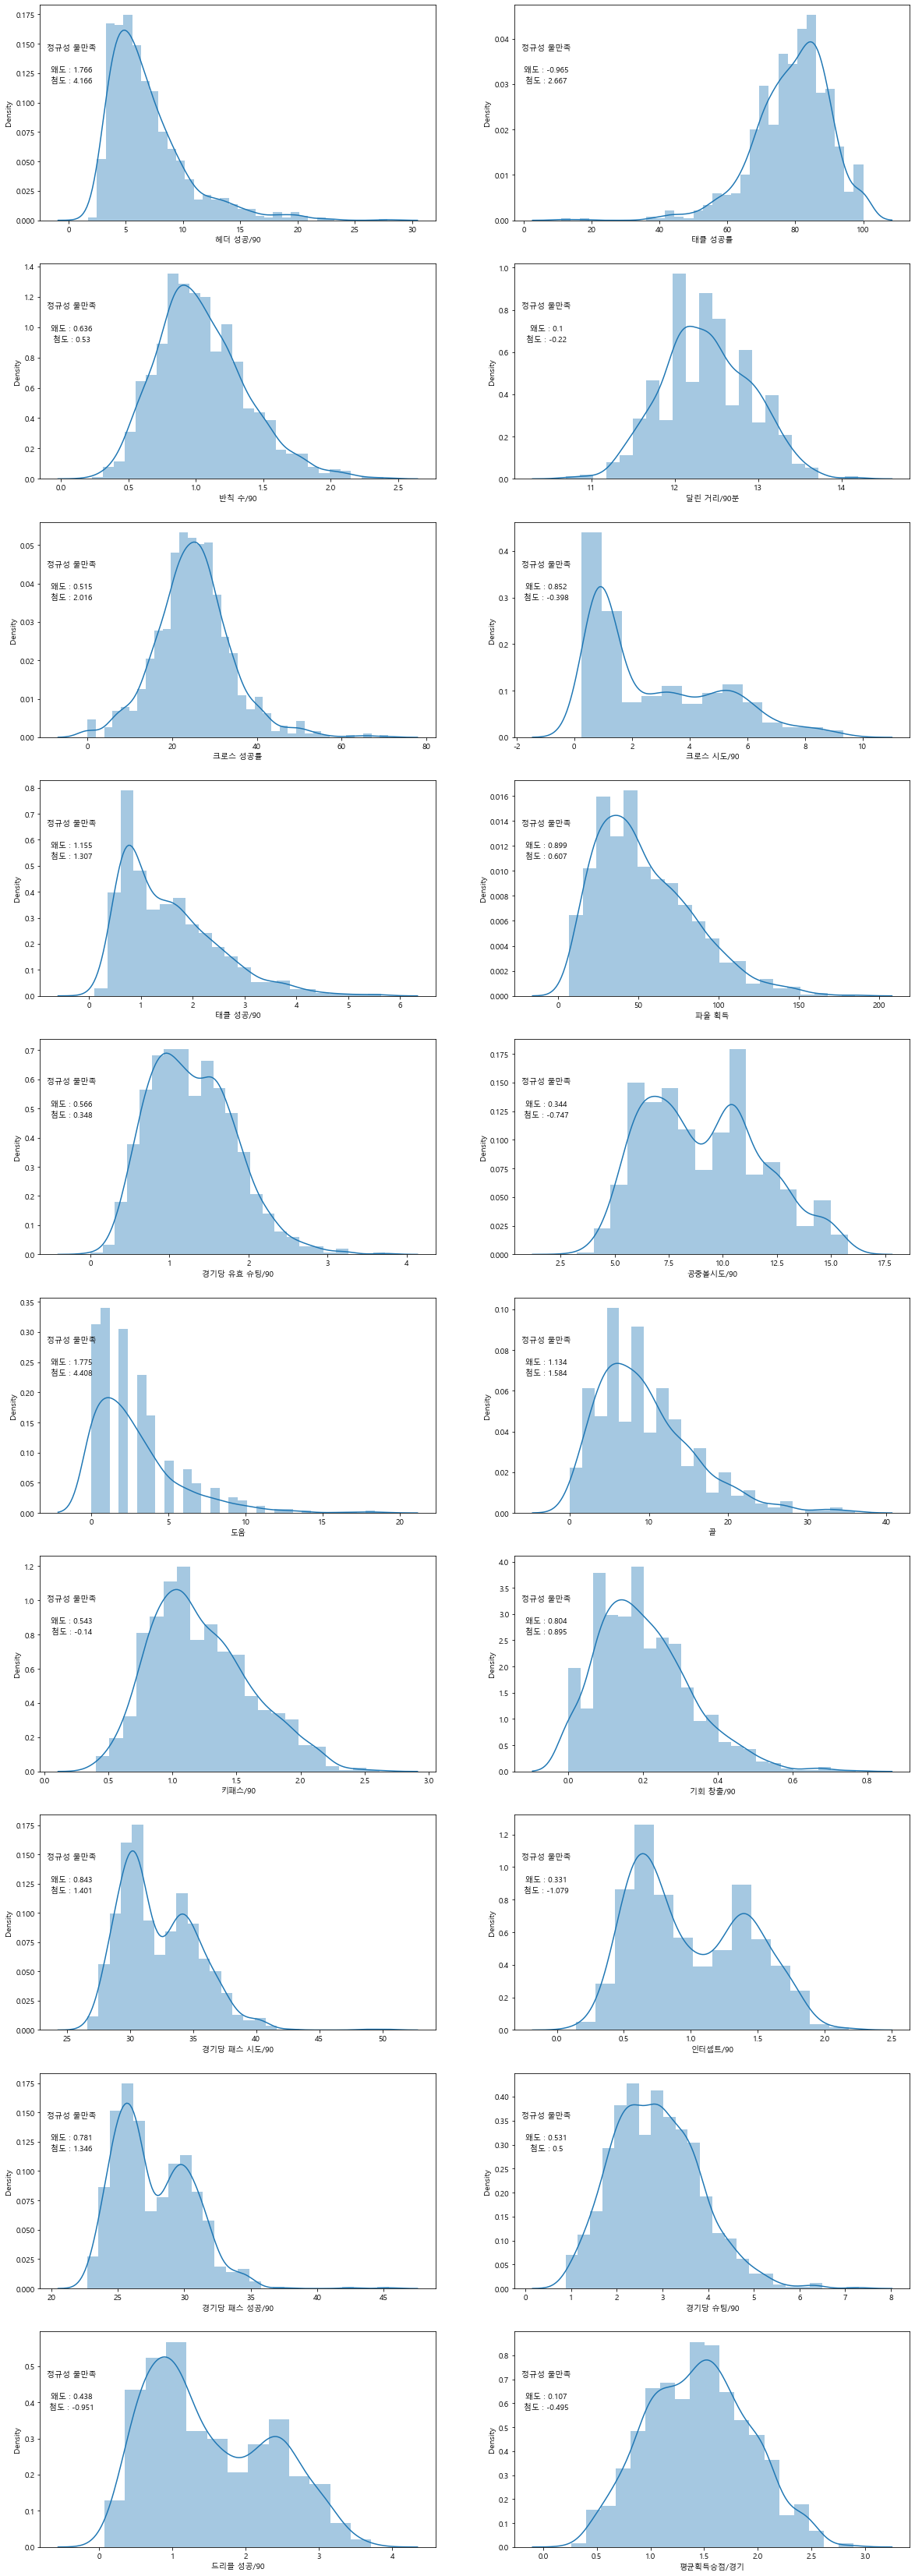

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = forward_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = forward_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

## 선형성 검정

모든 변수 선형성 만족

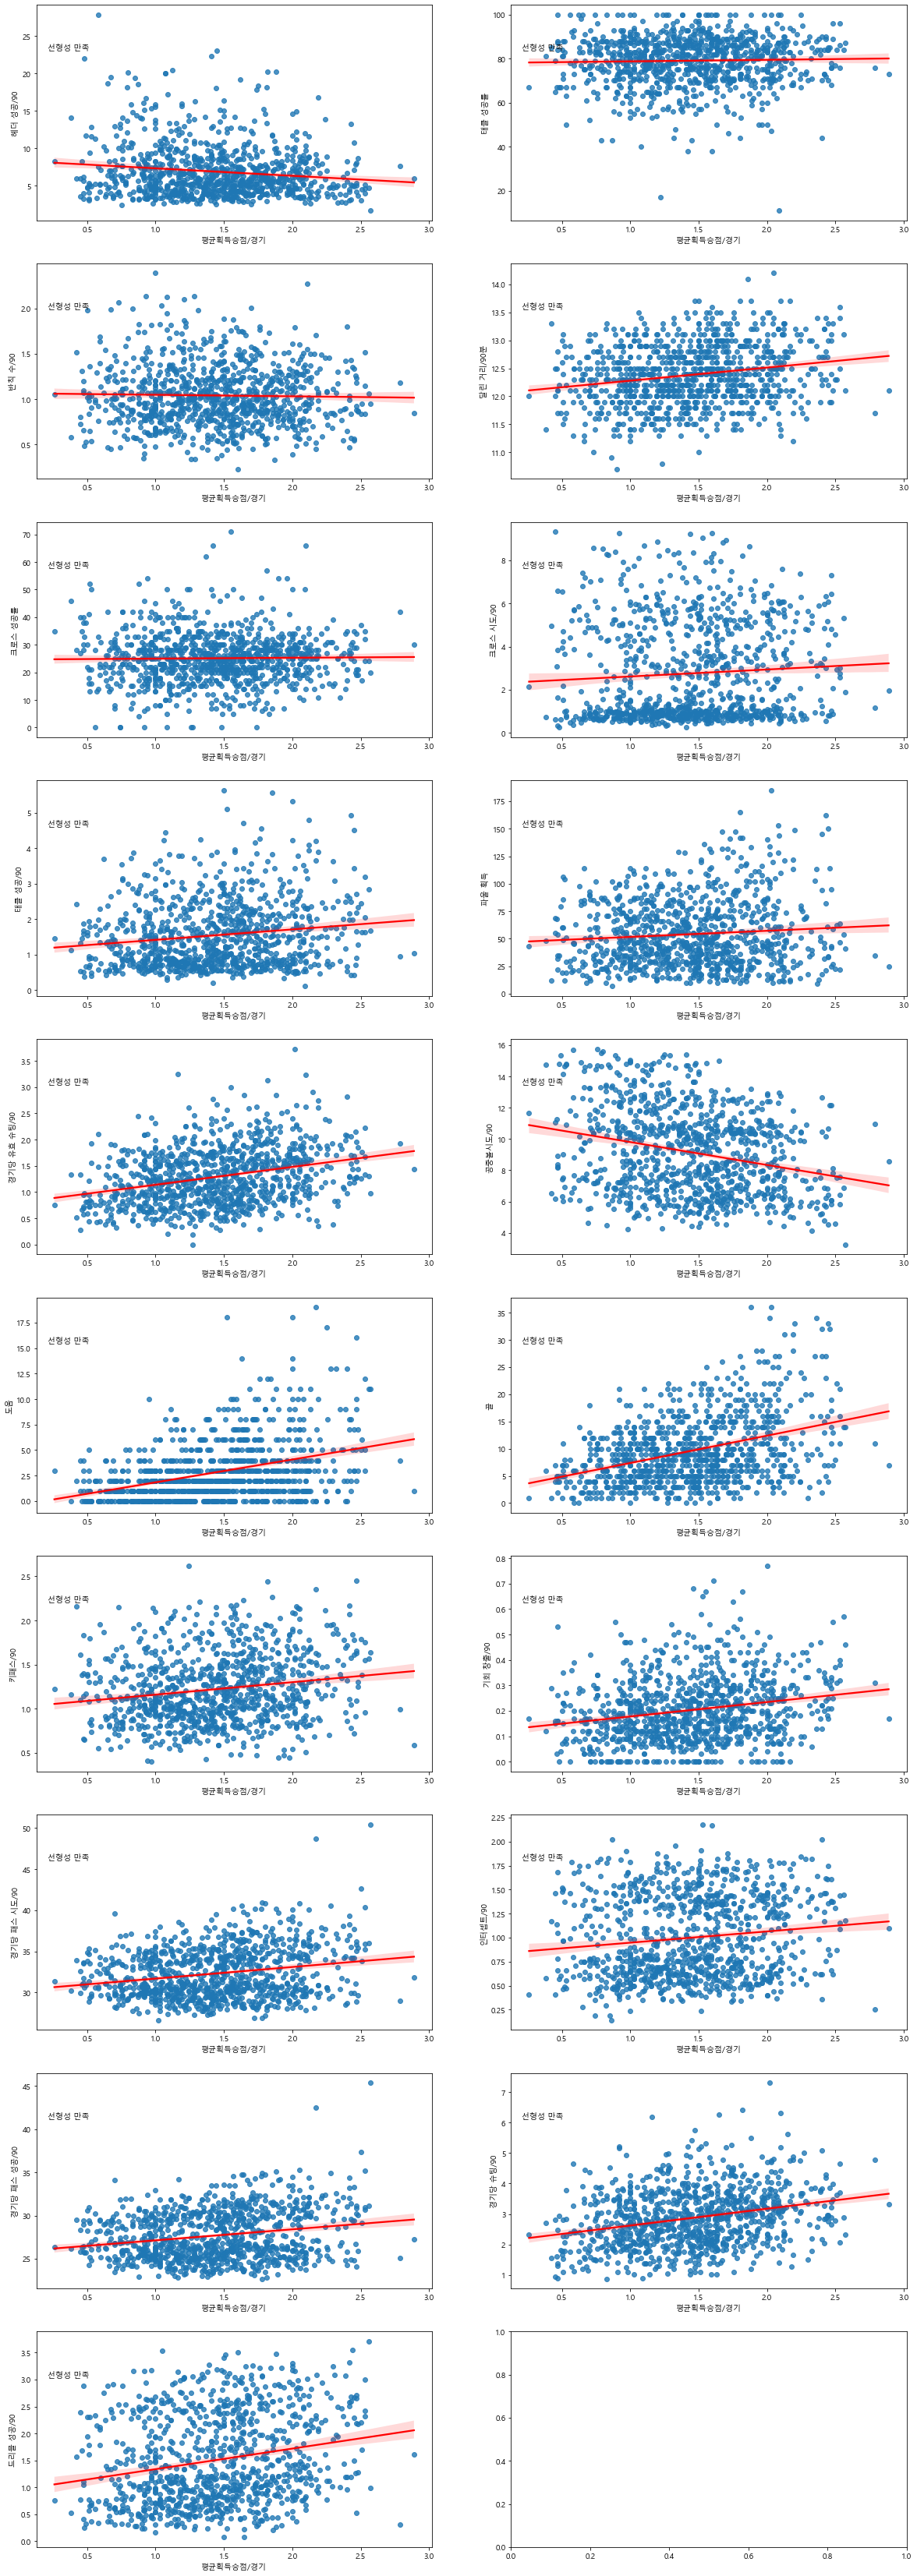

In [6]:
figs , axes = plt.subplots(10,2,figsize=(20,60))


# 독립변수 시각화
for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    sns.regplot(x=dependent_value,y=feature,data=forward_df,line_kws={'color': 'red'},ax=ax)
    model = smf.OLS(forward_df[dependent_value],forward_df[feature]).fit()
    lin_p = sms.linear_rainbow(model,frac=0.5)[1]
    if lin_p>= 0.1: 
        ax.text(x=0.08,y=0.8,s='선형성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='선형성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

## 이상치 탐지

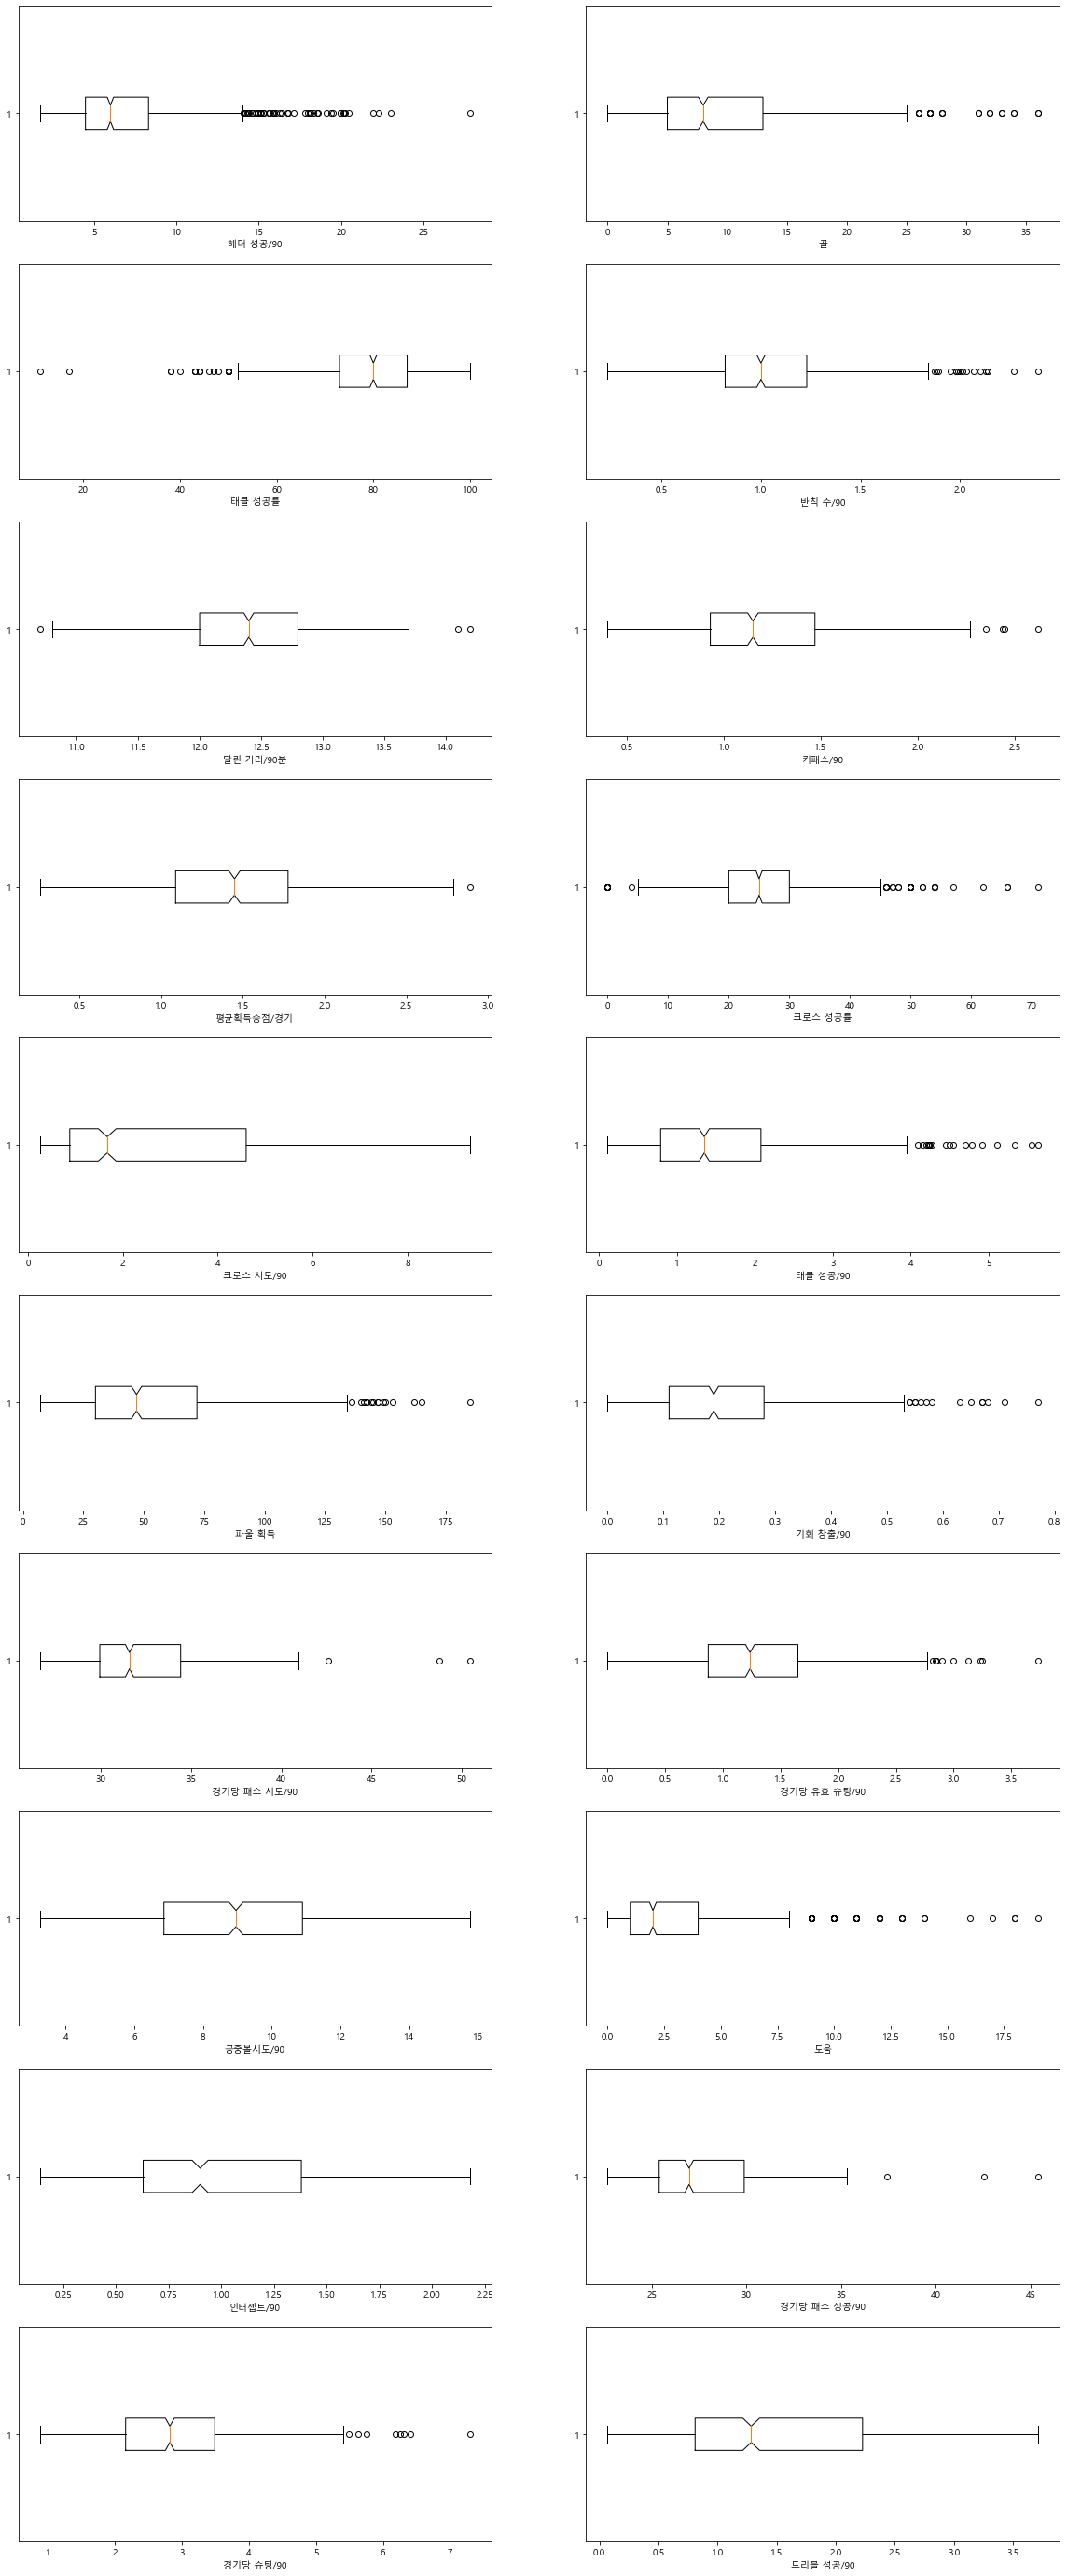

In [7]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value | set([dependent_value]))) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [8]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 990개의 데이터 중 {len(total)} 개 입니다.')

헤더 성공/90중 이상치는 76개 비율은 약 7.677% 입니다

태클 성공률중 이상치는 23개 비율은 약 2.323% 입니다

반칙 수/90중 이상치는 34개 비율은 약 3.434% 입니다

달린 거리/90분중 이상치는 5개 비율은 약 0.505% 입니다

크로스 성공률중 이상치는 48개 비율은 약 4.848% 입니다

크로스 시도/90중 이상치는 14개 비율은 약 1.414% 입니다

태클 성공/90중 이상치는 43개 비율은 약 4.343% 입니다

파울 획득중 이상치는 26개 비율은 약 2.626% 입니다

경기당 유효 슈팅/90중 이상치는 15개 비율은 약 1.515% 입니다

공중볼시도/90중 이상치는 0개 비율은 약 0.0% 입니다

도움중 이상치는 101개 비율은 약 10.202% 입니다

골중 이상치는 36개 비율은 약 3.636% 입니다

키패스/90중 이상치는 21개 비율은 약 2.121% 입니다

기회 창출/90중 이상치는 26개 비율은 약 2.626% 입니다

경기당 패스 시도/90중 이상치는 12개 비율은 약 1.212% 입니다

인터셉트/90중 이상치는 0개 비율은 약 0.0% 입니다

경기당 패스 성공/90중 이상치는 3개 비율은 약 0.303% 입니다

경기당 슈팅/90중 이상치는 16개 비율은 약 1.616% 입니다

드리블 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

이상치가 있는 row의 갯수는 총 990개의 데이터 중 363 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인 - 독립성 검정

### 상관계수

#### 상관계수 시각화

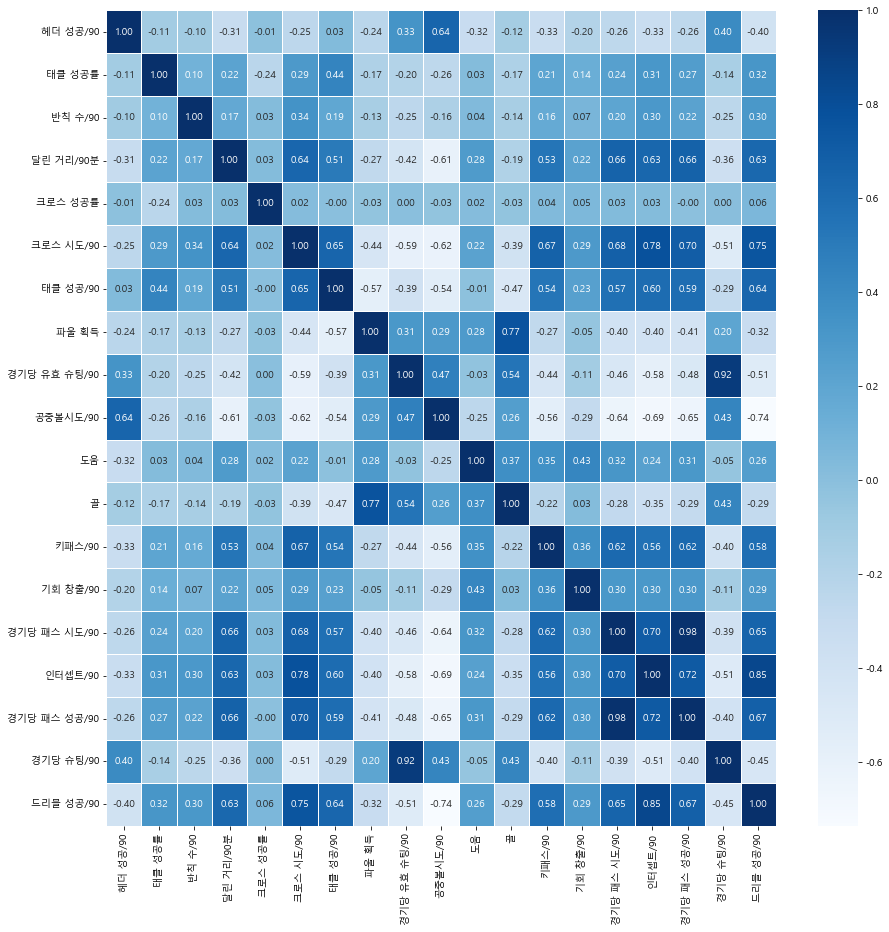

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(data = forward_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues');

#### 독립변수 간 상관계수가 0.9이상인 변수들

In [10]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 유효 슈팅/90,경기당 슈팅/90,0.917105
1,경기당 패스 시도/90,경기당 패스 성공/90,0.975391


#### 종속변수와 독립변수간 상관계수

In [11]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(forward_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수']).head(20)

,종속변수,독립변수,상관계수
0,도움,평균획득승점/경기,0.355723
1,골,평균획득승점/경기,0.339638
2,경기당 유효 슈팅/90,평균획득승점/경기,0.294253
3,경기당 슈팅/90,평균획득승점/경기,0.270670
4,공중볼시도/90,평균획득승점/경기,-0.233310
5,드리블 성공/90,평균획득승점/경기,0.226529
6,기회 창출/90,평균획득승점/경기,0.210937
7,달린 거리/90분,평균획득승점/경기,0.195275
8,경기당 패스 시도/90,평균획득승점/경기,0.179314
9,키패스/90,평균획득승점/경기,0.176536


### 다중공선성 확인

In [12]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,3.755828,도움
1,4.868736,기회 창출/90
2,9.599945,크로스 성공률
3,9.744943,크로스 시도/90
4,12.683002,반칙 수/90
5,13.139745,골
6,13.981737,태클 성공/90
7,15.608509,파울 획득
8,18.991858,헤더 성공/90
9,21.384806,드리블 성공/90


## EDA Summary


- 모든 독립변수는 선형성을 만족한다.
- 이상치가 있는 row를 모두 삭제한다면 data loss가 너무 크므로 이상치에 강건한 스케일링을 활용해야 한다.
- 상관계수가 높은 독립변수간 상관관계제거, 다중공선성 해결 필요

# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [13]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [14]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(forward_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

In [15]:
def check_dependent_corr(independent_value):
    corr_dict_dependent = {}
    corr_list_dependent = []

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for val in independent_value:
        spearmann = spearmanr(forward_df[[val,dependent_value]])
        corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
        corr_list_dependent.append([val,dependent_value,spearmann[0]])

    df = pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수'])
    return df

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골,경기당 슈팅, 유효 슈팅
2. 도움, 패스시도,패스성공,키패스
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 크로스시도 크로스 성공
8. 파울 획득
9. 반칙 수 /90
10. 달린거리/90분

### 골과 경기당 슈팅, 유효슈팅

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [16]:
forward_df[['골','경기당 유효 슈팅/90','경기당 슈팅/90','평균획득승점/경기']].corr()

,골,경기당 유효 슈팅/90,경기당 슈팅/90,평균획득승점/경기
골,1.000000,0.542463,0.432573,0.384443
경기당 유효 슈팅/90,0.542463,1.000000,0.920149,0.298534
경기당 슈팅/90,0.432573,0.920149,1.000000,0.273705
평균획득승점/경기,0.384443,0.298534,0.273705,1.000000


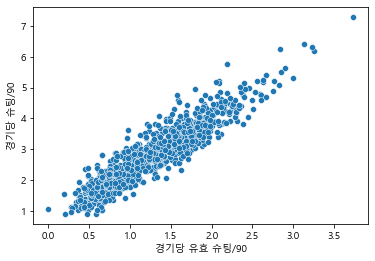

In [17]:
sns.scatterplot(x='경기당 유효 슈팅/90',y='경기당 슈팅/90',data=forward_df);

#### 피쳐 엔지니어링

In [18]:
# Goal_Shoot_linear
forward_df['GSL'] = (forward_df['경기당 유효 슈팅/90']+0.5) + (forward_df['경기당 슈팅/90']) + (forward_df['골']*1.3)

independent_value.add('GSL')
independent_value = independent_value - set(['골','경기당 슈팅/90','경기당 유효 슈팅/90'])

forward_df[['이름','GSL']].sort_values(by='GSL',ascending=False).head()

,이름,GSL
329,Erling Haaland,55.73
3,Erling Haaland,55.64
254,Romelu Lukaku,53.62
855,Erling Haaland,50.00
193,Kylian Mbappé,49.88


#### 상관계수 확인 (통과)

In [19]:
forward_df[['GSL','평균획득승점/경기']].corr()

,GSL,평균획득승점/경기
GSL,1.000000,0.397433
평균획득승점/경기,0.397433,1.000000


In [20]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.733315,도움
1,4.834551,기회 창출/90
2,9.329025,크로스 시도/90
3,9.551487,크로스 성공률
4,12.569933,GSL
5,12.636311,반칙 수/90
6,13.583344,파울 획득
7,13.952538,태클 성공/90
8,17.768711,헤더 성공/90
9,21.284243,드리블 성공/90


In [21]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수
0,경기당 패스 시도/90,경기당 패스 성공/90,0.975391


### 경기당 패스 성공/90 경기당 패스 시도/90

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [22]:
forward_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.981650,0.210931
경기당 패스 시도/90,0.981650,1.000000,0.217491
평균획득승점/경기,0.210931,0.217491,1.000000


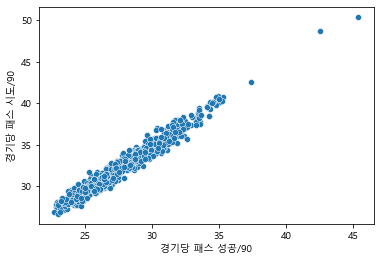

In [23]:
sns.scatterplot(x='경기당 패스 성공/90',y='경기당 패스 시도/90',data=forward_df);

#### 피쳐 엔지니어링

In [24]:
# PSTL = Pass sucess try linear

forward_df['PSTL'] = (forward_df['경기당 패스 성공/90']) + (forward_df['경기당 패스 시도/90'])

independent_value.add('PSTL')
independent_value = independent_value - set(['경기당 패스 성공/90','경기당 패스 시도/90'])

forward_df[['이름','PSTL']].sort_values(by='PSTL',ascending=False).head()

,이름,PSTL
547,Phil Foden,95.83
591,Kai Havertz,91.26
215,Phil Foden,80.02
256,Kai Havertz,76.11
480,Robert Navarro,75.87


#### 상관계수 확인 (통과)

In [25]:
forward_df[['PSTL','평균획득승점/경기']].corr()

,PSTL,평균획득승점/경기
PSTL,1.000000,0.215311
평균획득승점/경기,0.215311,1.000000


### 크로스 시도/90 크로스 성공률

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [26]:
forward_df[['크로스 시도/90','크로스 성공률','평균획득승점/경기']].corr()

,크로스 시도/90,크로스 성공률,평균획득승점/경기
크로스 시도/90,1.000000,0.022107,0.068254
크로스 성공률,0.022107,1.000000,0.016018
평균획득승점/경기,0.068254,0.016018,1.000000


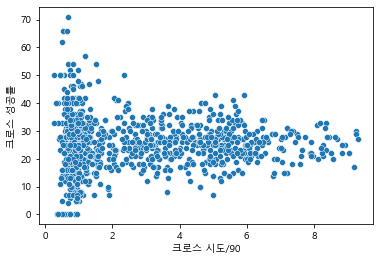

In [27]:
sns.scatterplot(x='크로스 시도/90',y='크로스 성공률',data=forward_df);

#### 피쳐 엔지니어링

In [28]:
# CACCL

forward_df['CACCL'] = (forward_df['크로스 시도/90']) + (forward_df['크로스 성공률'])

independent_value.add('CACCL')
independent_value = independent_value - set(['크로스 시도/90','크로스 성공률'])

forward_df[['이름','CACCL']].sort_values(by='CACCL',ascending=False).head()

,이름,CACCL
28,Lukas Nmecha,71.68
663,Donyell Malen,66.66
30,Brenner,66.54
966,Vincenzo Millico,62.49
742,Willian José,58.18


#### 상관계수 확인 (통과)

In [29]:
forward_df[['CACCL','평균획득승점/경기']].corr()

,CACCL,평균획득승점/경기
CACCL,1.000000,0.031629
평균획득승점/경기,0.031629,1.000000


### 피쳐 삭제

In [30]:
independent_value

{'CACCL',
 'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '달린 거리/90분',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '키패스/90',
 '태클 성공/90',
 '태클 성공률',
 '파울 획득',
 '헤더 성공/90'}

In [31]:
independent_value = independent_value - set(['달린 거리/90분','PSTL','공중볼시도/90','태클 성공률','인터셉트/90','키패스/90','반칙 수/90'])

In [32]:
check_dependent_corr(independent_value)

,종속변수,독립변수,상관계수
0,GSL,평균획득승점/경기,0.361062
1,도움,평균획득승점/경기,0.355723
2,드리블 성공/90,평균획득승점/경기,0.226529
3,기회 창출/90,평균획득승점/경기,0.210937
4,태클 성공/90,평균획득승점/경기,0.140787
5,헤더 성공/90,평균획득승점/경기,-0.093546
6,파울 획득,평균획득승점/경기,0.041972
7,CACCL,평균획득승점/경기,0.027181


In [33]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.188342,도움
1,4.612170,기회 창출/90
2,5.232369,헤더 성공/90
3,8.461593,CACCL
4,8.975342,태클 성공/90
5,9.670559,파울 획득
6,9.793386,드리블 성공/90
7,11.738122,GSL


In [34]:
independent_value

{'CACCL',
 'GSL',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '태클 성공/90',
 '파울 획득',
 '헤더 성공/90'}

In [35]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


### 최종 종속변수

In [36]:
independent_value

{'CACCL',
 'GSL',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '태클 성공/90',
 '파울 획득',
 '헤더 성공/90'}

In [37]:
forward_df.columns

Index(['이름', '포지션', '리그', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '시즌', 'GSL', 'PSTL', 'CACCL'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

In [38]:
x_train,x_test,y_train,y_test = train_test_split(forward_df.loc[:,independent_value],forward_df.loc[:,dependent_value])

forward_x_po = QuantileTransformer(output_distribution='normal').fit(x_train.loc[:,independent_value])

x_train.loc[:,independent_value] = forward_x_po.transform(x_train.loc[:,independent_value])
x_test.loc[:,independent_value] = forward_x_po.transform(x_test.loc[:,independent_value])

# 모델 생성

In [39]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(10,activation='relu')(inputs_layer)
hidden2 = Dense(256,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dense(256,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
hidden3 = Dense(20,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(x_train.loc[:,independent_value],y_train,batch_size=400,epochs=700,validation_data=(x_test.loc[:,independent_value],y_test))  
predict_result=model.predict(x_test.loc[:,independent_value])
mae = mean_absolute_error(y_test,predict_result)

Epoch 1/700
2/2 [==============================] - 0s 57ms/step - loss: 2.7288 - val_loss: 2.4801
Epoch 2/700
2/2 [==============================] - 0s 6ms/step - loss: 2.2616 - val_loss: 2.1279
Epoch 3/700
2/2 [==============================] - 0s 5ms/step - loss: 1.9410 - val_loss: 1.8981
Epoch 4/700
2/2 [==============================] - 0s 5ms/step - loss: 1.7563 - val_loss: 1.7642
Epoch 5/700
2/2 [==============================] - 0s 5ms/step - loss: 1.6712 - val_loss: 1.6711
Epoch 6/700
2/2 [==============================] - 0s 5ms/step - loss: 1.6035 - val_loss: 1.5829
Epoch 7/700
2/2 [==============================] - 0s 5ms/step - loss: 1.5281 - val_loss: 1.4919
Epoch 8/700
2/2 [==============================] - 0s 5ms/step - loss: 1.4370 - val_loss: 1.4005
Epoch 9/700
2/2 [==============================] - 0s 6ms/step - loss: 1.3418 - val_loss: 1.3141
Epoch 10/700
2/2 [==============================] - 0s 6ms/step - loss: 1.2548 - val_loss: 1.2383
Epoch 11/700
2/2 [==========

2/2 [==============================] - 0s 6ms/step - loss: 0.3221 - val_loss: 0.3462
Epoch 85/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3196 - val_loss: 0.3436
Epoch 86/700
2/2 [==============================] - 0s 5ms/step - loss: 0.3175 - val_loss: 0.3415
Epoch 87/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3159 - val_loss: 0.3399
Epoch 88/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3132 - val_loss: 0.3377
Epoch 89/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3108 - val_loss: 0.3353
Epoch 90/700
2/2 [==============================] - 0s 5ms/step - loss: 0.3088 - val_loss: 0.3333
Epoch 91/700
2/2 [==============================] - 0s 5ms/step - loss: 0.3067 - val_loss: 0.3312
Epoch 92/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3046 - val_loss: 0.3294
Epoch 93/700
2/2 [==============================] - 0s 5ms/step - loss: 0.3027 - val_loss: 0.3273
Epoch 94/700
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 0.2121 - val_loss: 0.2370
Epoch 168/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2113 - val_loss: 0.2361
Epoch 169/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2105 - val_loss: 0.2352
Epoch 170/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2098 - val_loss: 0.2344
Epoch 171/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2094 - val_loss: 0.2338
Epoch 172/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2083 - val_loss: 0.2333
Epoch 173/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2076 - val_loss: 0.2327
Epoch 174/700
2/2 [==============================] - 0s 7ms/step - loss: 0.2070 - val_loss: 0.2320
Epoch 175/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2063 - val_loss: 0.2314
Epoch 176/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2057 - val_loss: 0.2306
Epoch 177/700
2/2 [=====

Epoch 250/700
2/2 [==============================] - 0s 7ms/step - loss: 0.1711 - val_loss: 0.1960
Epoch 251/700
2/2 [==============================] - 0s 7ms/step - loss: 0.1703 - val_loss: 0.1947
Epoch 252/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1703 - val_loss: 0.1947
Epoch 253/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1696 - val_loss: 0.1943
Epoch 254/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1692 - val_loss: 0.1940
Epoch 255/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1690 - val_loss: 0.1929
Epoch 256/700
2/2 [==============================] - 0s 7ms/step - loss: 0.1682 - val_loss: 0.1925
Epoch 257/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1678 - val_loss: 0.1923
Epoch 258/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1674 - val_loss: 0.1921
Epoch 259/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1672 - val_loss: 0.1918
Epoch 260/

2/2 [==============================] - 0s 8ms/step - loss: 0.1504 - val_loss: 0.1749
Epoch 333/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1502 - val_loss: 0.1746
Epoch 334/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1503 - val_loss: 0.1746
Epoch 335/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1507 - val_loss: 0.1745
Epoch 336/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1498 - val_loss: 0.1743
Epoch 337/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1493 - val_loss: 0.1742
Epoch 338/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1495 - val_loss: 0.1737
Epoch 339/700
2/2 [==============================] - 0s 7ms/step - loss: 0.1490 - val_loss: 0.1738
Epoch 340/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1495 - val_loss: 0.1732
Epoch 341/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1490 - val_loss: 0.1732
Epoch 342/700
2/2 [=====

Epoch 415/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1398 - val_loss: 0.1645
Epoch 416/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1402 - val_loss: 0.1640
Epoch 417/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1400 - val_loss: 0.1644
Epoch 418/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1398 - val_loss: 0.1639
Epoch 419/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1403 - val_loss: 0.1640
Epoch 420/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1394 - val_loss: 0.1637
Epoch 421/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1396 - val_loss: 0.1635
Epoch 422/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1394 - val_loss: 0.1634
Epoch 423/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1390 - val_loss: 0.1638
Epoch 424/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1395 - val_loss: 0.1633
Epoch 425/

2/2 [==============================] - 0s 7ms/step - loss: 0.1335 - val_loss: 0.1575
Epoch 498/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1332 - val_loss: 0.1573
Epoch 499/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1335 - val_loss: 0.1570
Epoch 500/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1333 - val_loss: 0.1571
Epoch 501/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1332 - val_loss: 0.1573
Epoch 502/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1330 - val_loss: 0.1572
Epoch 503/700
2/2 [==============================] - 0s 8ms/step - loss: 0.1335 - val_loss: 0.1573
Epoch 504/700
2/2 [==============================] - 0s 26ms/step - loss: 0.1329 - val_loss: 0.1576
Epoch 505/700
2/2 [==============================] - 0s 7ms/step - loss: 0.1332 - val_loss: 0.1570
Epoch 506/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1327 - val_loss: 0.1569
Epoch 507/700
2/2 [====

Epoch 580/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1299 - val_loss: 0.1538
Epoch 581/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1288 - val_loss: 0.1547
Epoch 582/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1297 - val_loss: 0.1537
Epoch 583/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1291 - val_loss: 0.1540
Epoch 584/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1291 - val_loss: 0.1538
Epoch 585/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1290 - val_loss: 0.1534
Epoch 586/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1287 - val_loss: 0.1534
Epoch 587/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1290 - val_loss: 0.1532
Epoch 588/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1286 - val_loss: 0.1536
Epoch 589/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1289 - val_loss: 0.1533
Epoch 590/

2/2 [==============================] - 0s 10ms/step - loss: 0.1264 - val_loss: 0.1518
Epoch 663/700
2/2 [==============================] - ETA: 0s - loss: 0.123 - 0s 7ms/step - loss: 0.1260 - val_loss: 0.1514
Epoch 664/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1261 - val_loss: 0.1511
Epoch 665/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1258 - val_loss: 0.1515
Epoch 666/700
2/2 [==============================] - 0s 7ms/step - loss: 0.1258 - val_loss: 0.1512
Epoch 667/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1257 - val_loss: 0.1514
Epoch 668/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1257 - val_loss: 0.1515
Epoch 669/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1258 - val_loss: 0.1515
Epoch 670/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1255 - val_loss: 0.1510
Epoch 671/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1261 - val_loss: 0.1510

In [40]:
mae

0.2974435559417976

In [41]:
independent_value

{'CACCL',
 'GSL',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '태클 성공/90',
 '파울 획득',
 '헤더 성공/90'}

In [42]:
forward_df.loc[:,independent_value] = forward_x_po.transform(forward_df.loc[:,independent_value])

In [43]:
y_pred = model.predict(forward_df.loc[:,independent_value])

In [44]:
forward_df['예측_PPG'] = y_pred

In [45]:
forward_df.sort_values(by='예측_PPG',ascending=False).head(10)

,이름,포지션,리그,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,...,태클 성공/90,드리블 성공/90,헤더 성공/90,크로스 시도/90,평균획득승점/경기,시즌,GSL,PSTL,CACCL,예측_PPG
329,Erling Haaland,공격수,독일 분데스리가,34,1.792813,2.20,0.92,14.0,2.142670,0.70,...,-2.040281,0.069108,0.967422,0.75,2.02,2022-2023,5.199338,57.21,-1.377401,2.768365
3,Erling Haaland,공격수,독일 분데스리가,36,2.099048,2.10,1.34,13.0,2.131380,0.57,...,-0.235205,-0.606659,0.629647,0.82,1.88,2021-2022,5.199338,56.53,-1.463792,2.583901
344,Leroy Sané,공격수,독일 분데스리가,14,2.099048,2.71,0.63,24.0,0.226340,1.06,...,1.262938,5.199338,-0.565659,5.31,2.56,2022-2023,0.761630,67.11,0.107238,2.560409
194,Neymar,공격수,프랑스 리그 1,16,1.792813,2.26,0.71,34.0,0.178759,1.42,...,0.972949,1.856651,-1.175813,3.21,2.39,2021-2022,1.148678,63.05,1.103126,2.234092
856,Mohamed Salah,공격수,잉글랜드 프리미어 리그,24,2.775621,1.88,0.68,27.0,0.872529,1.09,...,-0.121139,1.374065,-1.015395,6.28,2.25,2023-2024,1.856651,67.03,0.625443,2.215410
855,Erling Haaland,공격수,잉글랜드 프리미어 리그,32,2.428737,1.99,0.74,35.0,2.397022,0.65,...,-1.642188,-0.419390,0.629647,1.25,2.40,2023-2024,2.993849,57.32,0.961923,2.212568
904,Gabriel Jesus,공격수,잉글랜드 프리미어 리그,14,2.641070,2.16,1.05,29.0,-0.201612,1.18,...,0.759325,1.225503,-0.281617,7.29,2.47,2023-2024,0.757023,66.74,0.967422,2.210745
347,Jamal Musiala,공격수,독일 분데스리가,21,2.266579,2.57,0.67,35.0,0.480525,0.84,...,0.228112,0.761630,-0.404357,2.57,2.53,2022-2023,1.581627,75.52,1.125049,2.205768
733,Manor Solomon,공격수,스페인 프리메라 디비전,20,2.428737,2.02,0.57,31.0,0.596316,0.85,...,0.391277,1.259114,-0.549526,4.80,2.28,2023-2024,1.434200,75.55,0.918940,2.202093
193,Kylian Mbappé,공격수,프랑스 리그 1,34,0.998201,2.23,0.68,26.0,1.705215,0.77,...,0.212194,0.926869,-2.131380,3.11,2.36,2021-2022,2.775621,58.63,0.089890,2.200941


# 모델검정

In [46]:
residual = forward_df['평균획득승점/경기'] - forward_df['예측_PPG']

## 잔차의 정규성 검정

In [47]:
# 정규성 만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9971098303794861, pvalue=0.07833854854106903)

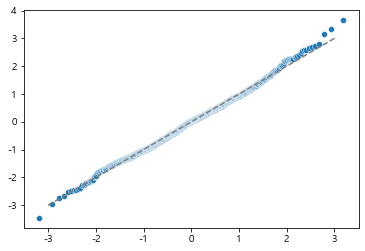

In [48]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey');

## 잔차의 등분산성 검정

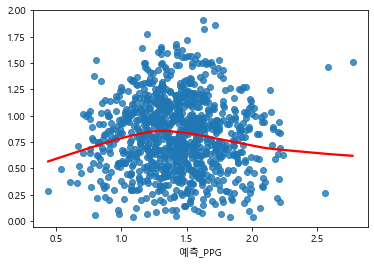

In [49]:
sns.regplot(forward_df['예측_PPG'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'});

In [50]:
# 등분산성 불만족
stats.levene(forward_df['평균획득승점/경기'],forward_df['예측_PPG'])

LeveneResult(statistic=157.3755803585024, pvalue=9.13483536281353e-35)

In [51]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

1.2600438975559338

In [52]:
mean_absolute_error(forward_df['평균획득승점/경기'],forward_df['예측_PPG'])

0.27109724962834225

In [53]:
np.sqrt(mean_squared_error(forward_df['평균획득승점/경기'],forward_df['예측_PPG']))

0.34115914058826036

In [56]:
with open('./models/forward/forward_qt.pickle','wb') as f:
     pickle.dump(forward_x_po,f)

In [57]:
model.save('./models/forward/forward_nn_high.h5')